# Предсказание цены автомобилей

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from matplotlib import pyplot as plt
import category_encoders as ce
from sklearn.model_selection import train_test_split
from catboost import Pool
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler

### Первым делом читаем датасет и дропаем колонки которые точно не будем использовать

In [2]:
df = pd.read_csv('vehicles.csv')
df = df.drop(['id', 'url', 'region_url', 'image_url','county', 'VIN', 'lat', 'long', 'title_status', 'region', 'posting_date'], axis=1)
df = df.drop(['description'], axis=1)

### Посмотрим на заполненность колонок

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   cylinders     249202 non-null  object 
 6   fuel          423867 non-null  object 
 7   odometer      422480 non-null  float64
 8   transmission  424324 non-null  object 
 9   drive         296313 non-null  object 
 10  size          120519 non-null  object 
 11  type          334022 non-null  object 
 12  paint_color   296677 non-null  object 
 13  state         426880 non-null  object 
dtypes: float64(2), int64(1), object(11)
memory usage: 45.6+ MB


### Разбираться с фичами начнем с цены

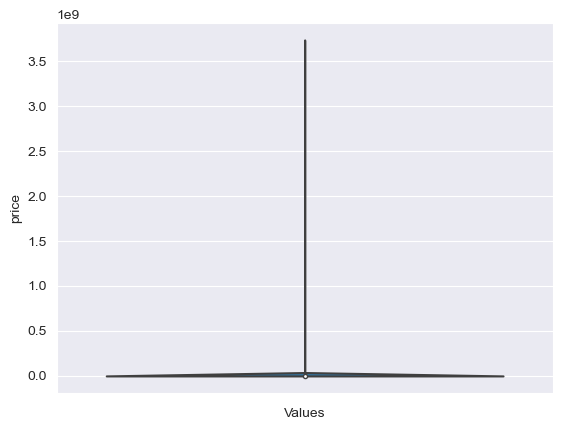

In [4]:
col = 'price'
df.replace(0, np.NaN)
data = df[col]
sns.violinplot(y=data)
plt.ylabel(col)
plt.xlabel('Values')
plt.show()

#### Картина удручающая, избавляемся от выбросов и проверяем результат, перед этим дропнем "бесплатные" автомобили

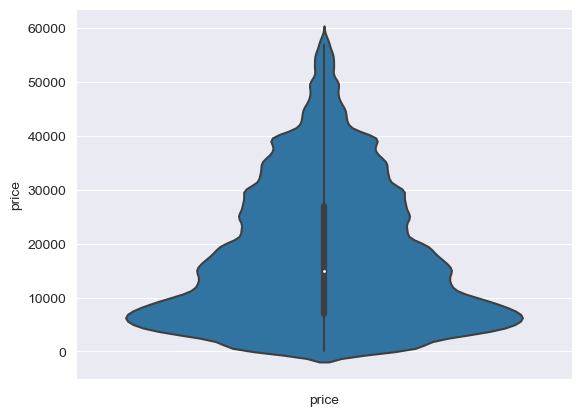

In [5]:
df = df[df[col] != 0]

Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

data = df[col]
sns.violinplot(y=data)
plt.xlabel(col)
plt.show()

#### Нормальным распределением тут и не пахнет, но стало определенно лучше

#### Перейдем к другим параметрам

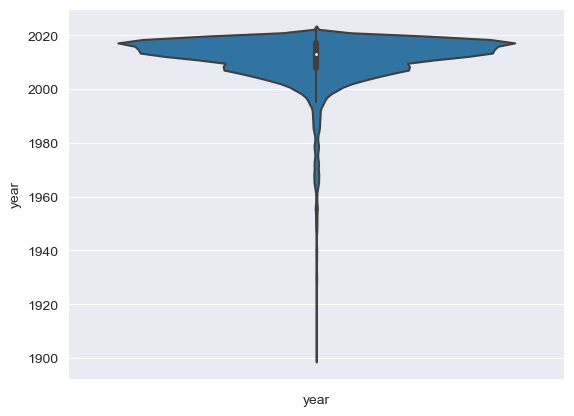

In [6]:
col = 'year'
data = df[col]
sns.violinplot(y=data)
plt.xlabel(col)
plt.show()

#### Избавимся от выбросов и заменим пропущенные значения на медиану, и нормализуем данные

        price    year manufacturer                     model  condition   
27      33590  2014.0          gmc  sierra 1500 crew cab slt       good  \
28      22590  2010.0    chevrolet            silverado 1500       good   
29      39590  2020.0    chevrolet       silverado 1500 crew       good   
30      30990  2017.0       toyota      tundra double cab sr       good   
31      15000  2013.0         ford                 f-150 xlt  excellent   
...       ...     ...          ...                       ...        ...   
426875  23590  2019.0       nissan         maxima s sedan 4d       good   
426876  30590  2020.0        volvo  s60 t5 momentum sedan 4d       good   
426877  34990  2020.0     cadillac          xt4 sport suv 4d       good   
426878  28990  2018.0        lexus           es 350 sedan 4d       good   
426879  30590  2019.0          bmw  4 series 430i gran coupe       good   

          cylinders    fuel  odometer transmission drive       size   
27      8 cylinders     gas 

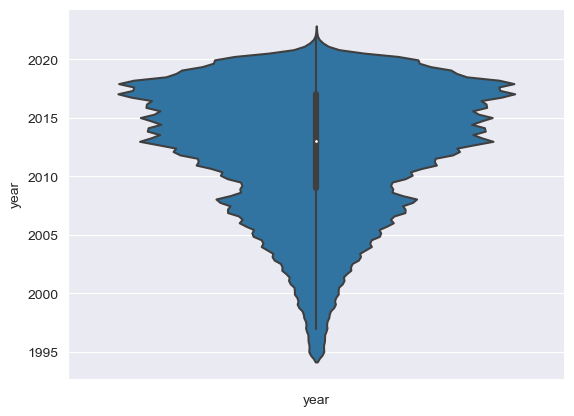

In [7]:
Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

df[col].fillna(df[col].median(), inplace=True)

ss = StandardScaler()
#df[col] = ss.fit_transform(df[col].values.reshape(-1, 1))

# Выводим результат
print(df)

data = df[col]
sns.violinplot(y=data)
plt.xlabel(col)
plt.show()

#### С производителем ничего не сделаешь, так что в дальнейшем дропнем строки где параметр не заполнен

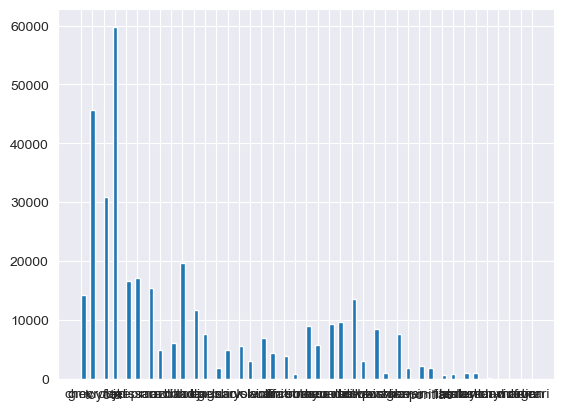

In [8]:
col = 'manufacturer'

df[col].hist(bins=100)
plt.show()

#### Модель - текстовый параметр, так что трогать его не будем

#### Пропущенные condition заменим на good как на наиболее частое и нейтральное значение

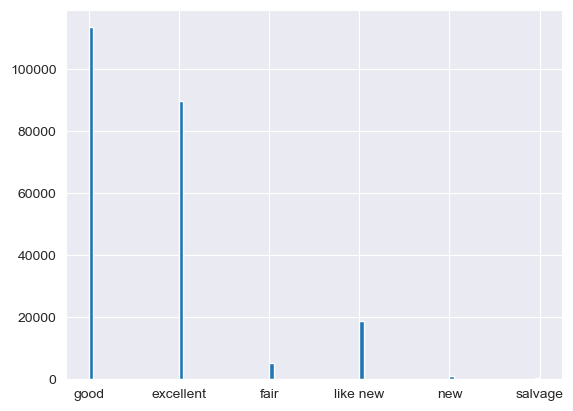

In [9]:
col = 'condition'

df[col].hist(bins=100)
plt.show()

#df[col].fillna('good', inplace=True)

#### Количество цилиндров с болью заменим на моду

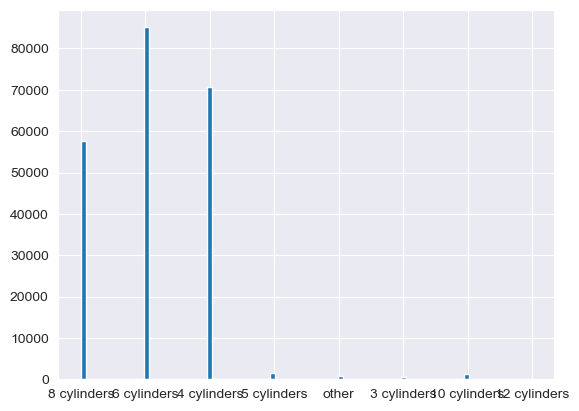

In [10]:
col = 'cylinders'

df[col].hist(bins=100)
plt.show()

df[col].fillna(df[col].mode()[0], inplace=True)

#### Пропущенный тип топлива смело заменяем на gas

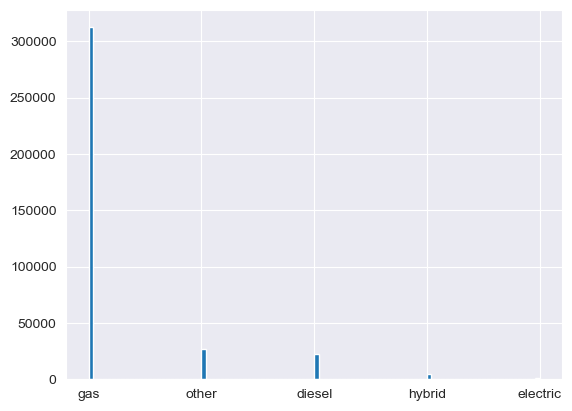

In [11]:
col = 'fuel'

df[col].hist(bins=100)
plt.show()

df[col].fillna(df[col].mode()[0], inplace=True)

#### Для пробега чиним выбросы, заменяем пропуски на медиану и нормализуем

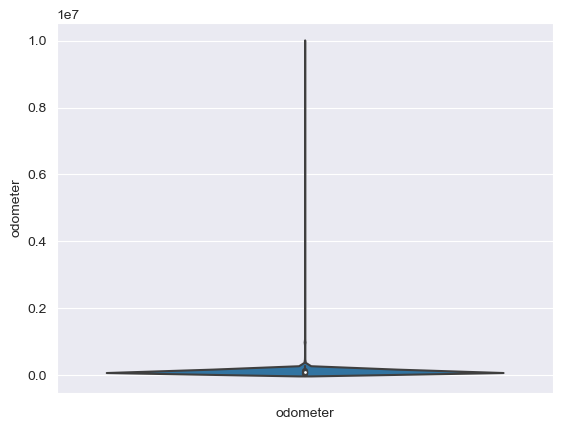

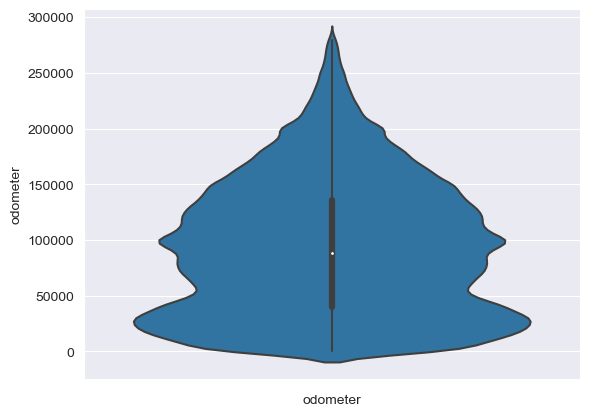

In [12]:
col = 'odometer'

data = df[col]
sns.violinplot(y=data)
plt.xlabel(col)
plt.show()

Q1 = df[col].quantile(0.25)
Q3 = df[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

df[col].fillna(df[col].median(), inplace=True)

#df[col] = ss.fit_transform(df[col].values.reshape(-1, 1))

data = df[col]
sns.violinplot(y=data)
plt.xlabel(col)
plt.show()

#### Пропуски в трансмиссии заменяем на моду

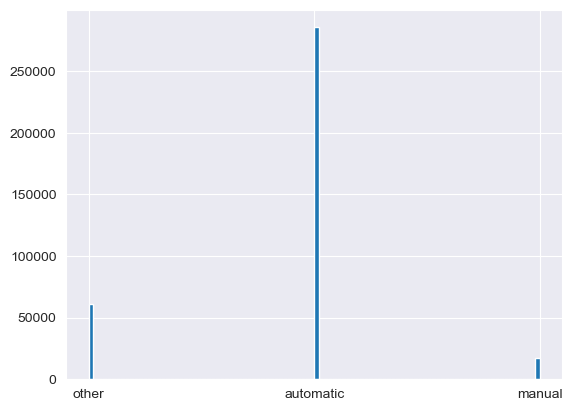

In [13]:
col = 'transmission'

df[col].hist(bins=100)
plt.show()

df[col].fillna(df[col].mode()[0], inplace=True)

#### Привод оставляем как есть

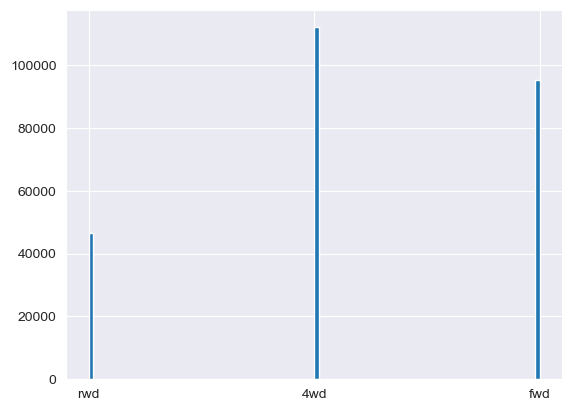

In [14]:
col = 'drive'

df[col].hist(bins=100)
plt.show()

#### Значание size заполнено только у трети записей, на что оптимальнее заменить - неясно. Дропнем колонку

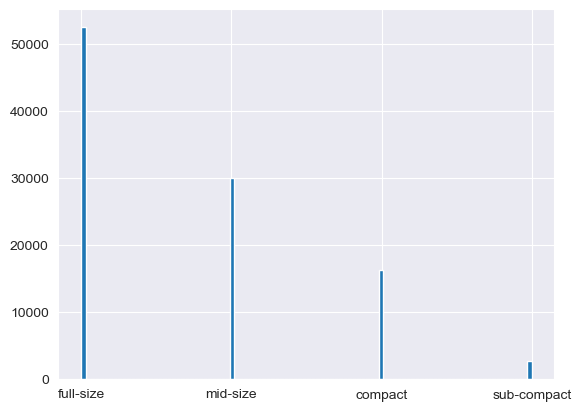

In [15]:
col = 'size'

df[col].hist(bins=100)
plt.show()

df=df.drop([col], axis=1)

#### Type оставим без изменений

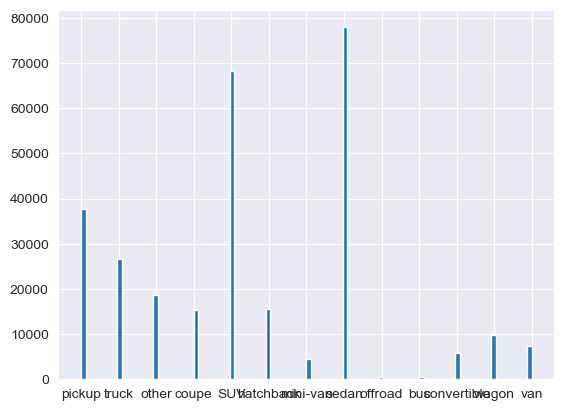

In [16]:
col = 'type'

df[col].hist(bins=100)
plt.show()

#### Пропуски в цвете заменим на белый, как на наиболее частое и нейтральное значение

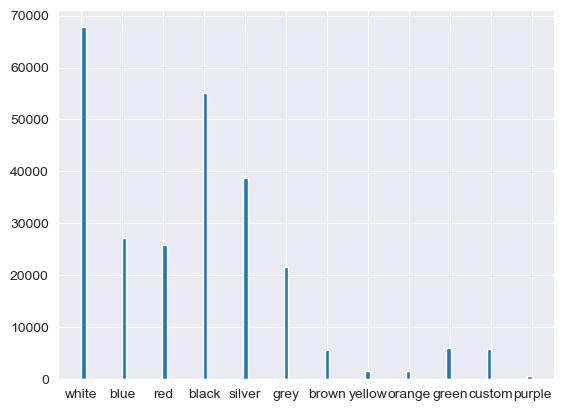

In [17]:
col = 'paint_color'

df[col].hist(bins=100)
plt.show()

df[col].fillna(df[col].mode()[0], inplace=True)

#### Пропущенные значения штата заменим на моду, в предположении что это не окажет сильного влияния на определение цены в дальнейшем

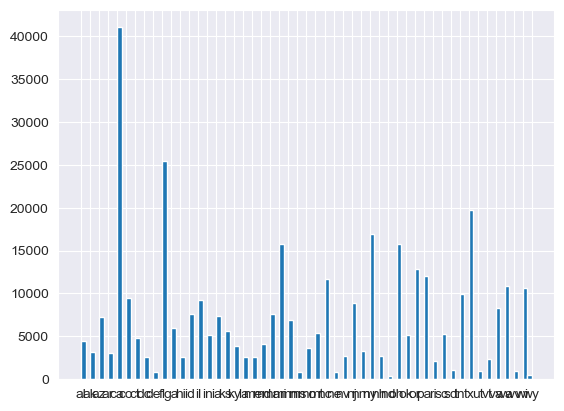

In [18]:
col = 'state'

df[col].hist(bins=100)
plt.show()

df[col].fillna(df[col].mode()[0], inplace=True)

### Удалим строки с пропусками

In [19]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148863 entries, 31 to 426879
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         148863 non-null  int64  
 1   year          148863 non-null  float64
 2   manufacturer  148863 non-null  object 
 3   model         148863 non-null  object 
 4   condition     148863 non-null  object 
 5   cylinders     148863 non-null  object 
 6   fuel          148863 non-null  object 
 7   odometer      148863 non-null  float64
 8   transmission  148863 non-null  object 
 9   drive         148863 non-null  object 
 10  type          148863 non-null  object 
 11  paint_color   148863 non-null  object 
 12  state         148863 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 15.9+ MB


### Посмотрим как коррелируют наши величины, перед этим закодируем категориальные переменные

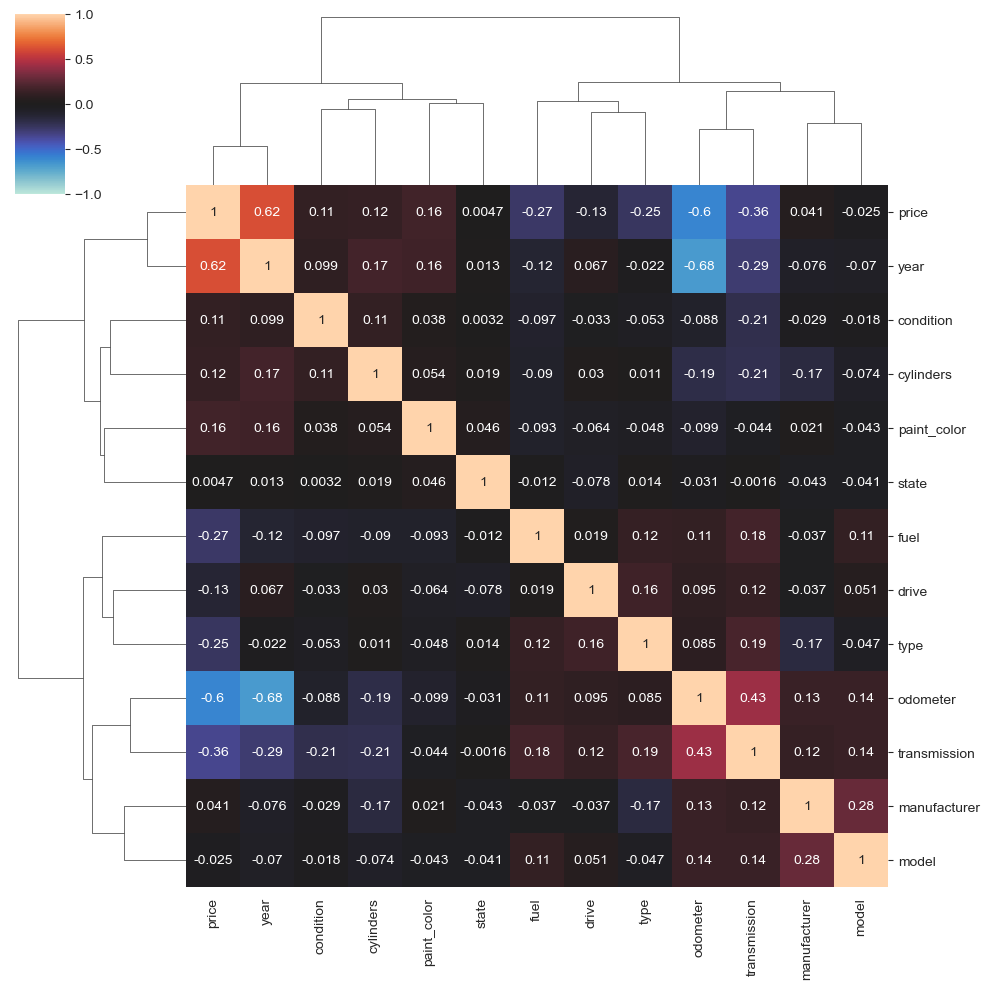

In [20]:
encoder = ce.CountEncoder()
df_num = encoder.fit_transform(df)

def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        #select_dtypes([np.number])
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_num)

### Начнем готовить данные для использования модели

In [21]:
target = 'price'
features = list(df.columns)
features.remove(target)
X = df[features]
y = df[[target]]

In [22]:
features

['year',
 'manufacturer',
 'model',
 'condition',
 'cylinders',
 'fuel',
 'odometer',
 'transmission',
 'drive',
 'type',
 'paint_color',
 'state']

### Определим индексы категориальных и текстовых переменных

In [23]:
cat_features = [1, 3, 4, 5, 7, 8, 9, 10, 11]
#cat_features = [1, 3, 4, 5, 7, 8, 9]
text_features = [2]

### Произведем train-test split (поплачем что только на данном этапе)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values.reshape(-1), train_size=0.8, shuffle=True)

train_pool = Pool(
    data = X_train,
    label = y_train,
    cat_features = cat_features,
    text_features=text_features,
)

test_pool = Pool(
    data = X_test,
    label = y_test,
    cat_features = cat_features,
    text_features=text_features,
)

### Обучим модель CatBoostRegressor, будем обучать до тех пор пока ошибка не начнет расти

In [25]:
model = CatBoostRegressor(iterations=10000,
                          cat_features=cat_features,
                          text_features=text_features,
                          loss_function='RMSE',
                          task_type='GPU',
                          early_stopping_rounds=100,
                          depth=8,
                          )

In [27]:
model.fit(train_pool,
          eval_set=test_pool,
          verbose=False,
          plot=True,
          )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [28]:
model.get_feature_importance(data=test_pool,
                             type='LossFunctionChange')

array([2835.39044642,   26.4503756 , 3671.0099826 ,   26.15390565,
         22.96559821,    5.2577731 , 1308.19035578,   10.18798829,
        165.42654018,  237.29087415,  129.0036535 ,  182.9387065 ])

In [29]:
features

['year',
 'manufacturer',
 'model',
 'condition',
 'cylinders',
 'fuel',
 'odometer',
 'transmission',
 'drive',
 'type',
 'paint_color',
 'state']

In [30]:
model.save_model(fname='10k_only_cond')

In [31]:
preds = model.predict(X_test)

In [41]:
np.column_stack((preds, y_test))

array([[19091.72366985, 17995.        ],
       [44003.70139599, 27800.        ],
       [27502.02108614, 25990.        ],
       ...,
       [20664.17949518, 23900.        ],
       [20498.91405114, 28500.        ],
       [ 9549.30197142,  8495.        ]])

In [40]:
X_test

array([[2013.0, 'chevrolet', 'express passenger', ..., 'van', 'silver',
        'pa'],
       [2019.0, 'ford', 'f-150', ..., 'pickup', 'grey', 'ca'],
       [2018.0, 'mazda', 'mx-5 miata grand touring', ..., 'other',
        'white', 'ny'],
       ...,
       [2015.0, 'mercedes-benz', 'gl-class', ..., 'wagon', 'silver',
        'wi'],
       [2011.0, 'ram', '2500', ..., 'truck', 'black', 'tn'],
       [2012.0, 'jeep', 'liberty', ..., 'SUV', 'red', 'pa']], dtype=object)

In [34]:
shap_values = model.get_feature_importance(
    test_pool,
    'ShapValues'
)
expected_value = shap_values[0, -1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

(29773, 12)


In [36]:
import shap

shap.initjs()

C:\Users\tosha\anaconda3\envs\my_env\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
C:\Users\tosha\anaconda3\envs\my_env\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_

In [37]:
shap.force_plot(expected_value, shap_values[1, :], X_test[1, :])

In [38]:
shap.force_plot(expected_value, shap_values[4, :], X_test[4, :])

In [39]:
shap.force_plot(expected_value, shap_values[12, :], X_test[12, :])